# [모듈 6.1] 추론 및 결과 분석

이 노트북은 이전 노트북에서 생성한 앤드포인트를 대상으로 실제 추론을 하여, 평가 결과를 얻습니다. 테스트 데이터 세트는 1000개를 사용하여 결과를 확인 합니다.
- 0. 기본 세이지 메이커 정보 및 기본 변수 로딩
- 1. 테스트 데이터 세트 로딩
- 2. 추론할 Payload 생성
- 3. 추론 실행
- 4. 예측의 확률값을 0, 1로 변화하여 리포팅
- 5. 엔드포인트 삭제

---
### 노트북 커널
- 이 워크샵은 노트북 커널이 `conda_python3` 를 사용합니다. 다른 커널일 경우 변경 해주세요.
---



## 0. 기본 세이지 메이커 정보 및 기본 변수 로딩

In [17]:
import boto3
import sagemaker
import pandas as pd

region = boto3.Session().region_name
sagemaker_session = sagemaker.session.Session()
role = sagemaker.get_execution_role()

%store -r all_adv_pipeline_endpoint_name

아래는 사용자 정의의 함수를 로딩 할때마다, 캐시에 있는 것보다는 원본을 로딩함.

In [18]:
all_adv_pipeline_endpoint_name

'lambda-deploy-endpoint-08-25-13-04-27'

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. 테스트 데이터 세트 로딩

In [20]:
import os
test_preproc_dir_artifact_file= os.path.join(test_preproc_dir_artifact, 'test.csv')
test_df = pd.read_csv(test_preproc_dir_artifact_file)
test_df.head()

,fraud,vehicle_claim,total_claim_amount,customer_age,months_as_customer,num_claims_past_year,num_insurers_past_5_years,policy_deductable,policy_annual_premium,customer_zip,...,collision_type_missing,incident_severity_Major,incident_severity_Minor,incident_severity_Totaled,authorities_contacted_Ambulance,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Police,police_report_available_No,police_report_available_Yes
0,0,23901.432507,36201.432507,56,118,0,1,750,3000,98039,...,0,0,0,1,0,0,0,1,0,1
1,0,29095.295736,73695.295736,36,71,0,1,750,2650,95307,...,0,0,0,1,0,0,0,1,0,1
2,0,11232.831826,25032.831826,24,11,1,4,750,3000,98391,...,0,0,1,0,0,0,1,0,1,0
3,0,11125.579356,25125.579356,23,65,0,1,750,3000,91302,...,0,0,1,0,0,0,1,0,1,0
4,0,4529.773913,22329.773913,37,142,0,1,750,3000,90744,...,0,0,1,0,0,0,0,1,1,0


## 2. 추론할 Payload 생성

- 추론에 입력될 CST String 형태의 데이터로 변경 (payload)

In [21]:
def get_payload_list(test_df, label_col):
    '''
    CSV String 행태로 변경
    '''
    s = test_df.drop(columns=[label_col])
    s = s.to_csv(header=None, index=None)
    payload_list = s.splitlines()
    return payload_list

payload_list = get_payload_list(test_df, label_col='fraud')
y_test = test_df['fraud'].tolist()

print("payload_list: \n", payload_list[0:1]) # 샘플로 5개의 리스트 보여줌.


payload_list: 
 ['23901.43250714285,36201.43250714285,56,118,0,1,750,3000,98039,2012,3,3,1,12300,9,12,3,14,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1']


## 3. 추론 실행
- 앤드포인트가 InServie로 유효하면 추론을 하여, 확률값을 제공함.
- 위에서 준비한 테스트 데이터 세트에서 실험적으로 5개의 샘플만을 추론을 함.
- [일람] 5.1 노트북 실행 완료 후에 약 10 분 이후에 아래 셀을 통한 추론이 가능합니다.
    - 앤드포인트의 생성을 위해서 약 10분 걸립니다. 
    - 이유는 앤드포인트 생성의 람다 스텝이 비동기로 실행 요청을 하고 완료가 되기 때문입니다.

In [23]:
%%time

import numpy as np
import boto3
sagemaker_boto_client = boto3.client('sagemaker')

from sagemaker.deserializers import CSVDeserializer
csv_deserializer = CSVDeserializer(accept='text/csv') # 디폴트가 accept가 'text/csv' 이지만 직관적 이유로 기술함.

from src.p_utils import is_available_endpoint, get_predictor, get_payload, predict, delete_endpoint

if is_available_endpoint(all_adv_pipeline_endpoint_name, verbose=False):
    pipeline_predictor = get_predictor(all_adv_pipeline_endpoint_name, sagemaker_session, csv_deserializer)
    pred_prob_list = []
    payload_list = get_payload_list(test_df, label_col='fraud')
    for payload in payload_list:
        pred_prob = predict(pipeline_predictor, payload)
        pred_prob_list.append(float(pred_prob[0]))
    print("pred_prob_list: \n", pred_prob_list[0:5])
else:
    print("Wait for creating an endpoint")

pred_prob_list: 
 [0.09844056516885757, 0.04594084993004799, 0.36358606815338135, 0.15541507303714752, 0.6878775358200073]
CPU times: user 1.9 s, sys: 96.3 ms, total: 1.99 s
Wall time: 11.5 s


## 4. 예측의 확률값을 0, 1로 변화하여 리포팅
- threshold 값이 보다 작으면 0, 크면 1로 할당한후에, Confustion Matrix로 보여줌

In [24]:
import matplotlib.pyplot as plt
import itertools
def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    plt.show()

#### 결과 해석

아래는 하나의 Confustion 행렬의 예로서, 해석의 방법은 아래와 같습니다.
- 전체 1000 개의 테스트 데이터 세트 이고, 이중에 33개 (7+26) 가 fraud 임. 
- 33개 중에서 26개를 잘 예측 했음 (fraud:1 에 대한 recall 이 0.79, 26/33). (True Positive, TP)
- 정상인 967 개 중에서 697개를 잘 예측 했음(fraud:0 에 대한 recall 이 0.72, 697/967). (True Negative, TN)
- 실제 fraud 이지만, 예측을 정상으로 한것이 7개 (False Negative, FN)
- 실제 정상이지만, fraud 로 예측한 것이 270개 (False Positive, FP)
    - 조금 더 상세한 의미는 인터넷에 많이 있습니다. 하나의 참조입니다.  --> [분류 성능 평가](https://datascienceschool.net/03%20machine%20learning/09.04%20분류%20성능평가.html) 

```
       legit fraud
legit   697   270
fraud     7    26
```

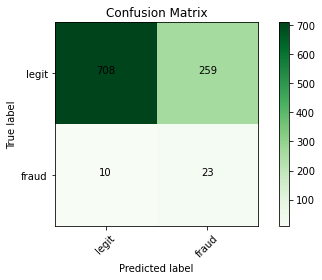

[[708 259]
 [ 10  23]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       967
           1       0.08      0.70      0.15        33

    accuracy                           0.73      1000
   macro avg       0.53      0.71      0.49      1000
weighted avg       0.96      0.73      0.82      1000



In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

threshold = 0.5
predictions = [1 if e >= threshold else 0 for e in pred_prob_list ] 
    

cm = confusion_matrix(y_true= y_test, y_pred= predictions)    
plot_conf_mat(cm, classes=['legit','fraud'], 
                  title='Confusion Matrix')
print(cm)

print(f"{classification_report(y_true=y_test, y_pred = predictions)}")


## 5. 엔드포인트 삭제
- **[중요] 과금을 막기 위해서 아래 코드를 꼭 수행 바랍니다.**
- is_del_model= True  를 통해서 생성한 모델 및 이전 파이프라인을 통한 엔드포인트 컨피그 와  엔드포인트를 삭제 합니다.

In [26]:
import boto3
boto3_client = boto3.client('sagemaker')
delete_endpoint(boto3_client, all_adv_pipeline_endpoint_name, is_del_model=True )



--- Deleted model: pipelines-e6svv5i5nej8-CreateFraudhModel-z4kxczHIey
--- Deleted endpoint: lambda-deploy-endpoint-08-25-13-04-27
--- Deleted endpoint_config: lambda-deploy-endpoint-config-08-25-13-04-27
